# Collaboration and Competition

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the third project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [9]:
from unityagents import UnityEnvironment
import numpy as np

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Tennis.app"`
- **Windows** (x86): `"path/to/Tennis_Windows_x86/Tennis.exe"`
- **Windows** (x86_64): `"path/to/Tennis_Windows_x86_64/Tennis.exe"`
- **Linux** (x86): `"path/to/Tennis_Linux/Tennis.x86"`
- **Linux** (x86_64): `"path/to/Tennis_Linux/Tennis.x86_64"`
- **Linux** (x86, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86"`
- **Linux** (x86_64, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86_64"`

For instance, if you are using a Mac, then you downloaded `Tennis.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Tennis.app")
```

In [10]:
env = UnityEnvironment(file_name="Tennis.app")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [11]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In this environment, two agents control rackets to bounce a ball over a net. If an agent hits the ball over the net, it receives a reward of +0.1.  If an agent lets a ball hit the ground or hits the ball out of bounds, it receives a reward of -0.01.  Thus, the goal of each agent is to keep the ball in play.

The observation space consists of 8 variables corresponding to the position and velocity of the ball and racket. Two continuous actions are available, corresponding to movement toward (or away from) the net, and jumping. 

Run the code cell below to print some information about the environment.

In [12]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agents and receive feedback from the environment.

Once this cell is executed, you will watch the agents' performance, if they select actions at random with each time step.  A window should pop up that allows you to observe the agents.

Of course, as part of the project, you'll have to change the code so that the agents are able to use their experiences to gradually choose better actions when interacting with the environment!

In [ ]:
for i in range(1, 6):                                      # play game for 5 episodes
    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    while True:
        actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
        actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        scores += env_info.rewards                         # update the score (for each agent)
        states = next_states                               # roll over states to next time step
        if np.any(dones):                                  # exit loop if episode finished
            break
    print('Score (max over agents) from episode {}: {}'.format(i, np.max(scores)))

When finished, you can close the environment.

In [ ]:
env.close()

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```

In [5]:
import torch
import numpy as np
from collections import deque
import os
import matplotlib.pyplot as plt
%matplotlib inline

from buffer import ReplayBuffer
from maddpg import MADDPG, MADDPGAgentTrainer

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
def seeding(seed=10):
    np.random.seed(seed)
    torch.manual_seed(seed)

In [7]:
def tennis(number_of_episodes=5000, episode_length=1000, print_every=100):
    """Multi Agent Deep Deterministic Policy Gradient (MADDPG) algorithm to train two agents to play tennis in the Unity environment.
    
    Params
    ======
        number_of_episodes (int): maximum number of training episodes
        episode_length (int): maximum number of timesteps per episode
        print_every (int): maximum number of last scores to track
    
    """
    
    update_every = 1                                            # how many episodes before update
     
    batch_size = 256                                            # minibatch size
    buffer_size = 1e6                                           # size of replay buffer
    gamma = 0.95                                                # discount factor
    tau = 1e-2                                                  # soft update of target parameters
    lr_actor = 1e-3                                             # actor learning rate
    lr_critic = 1e-3                                            # critic learning rate
    fc1 = 64                                                    # hidden layer 1
    fc2 = 64                                                    # hidden layer 2
    
    env_info = env.reset(train_mode=True)[brain_name]           # reset the environment
    num_agents = len(env_info.agents)                           # number of agents
    
    state = env_info.vector_observations
    state_shape = state.shape[1]
    action_size = brain.vector_action_space_size

    # initialize agents
    agent = MADDPGAgentTrainer(state_shape, fc1, fc2, action_size, num_agents, gamma, tau, lr_actor, lr_critic, buffer_size, batch_size, update_every, random_seed=48)
    
    # scores tracker
    best_score = -np.inf
    scores = []                                              # list containing scores from each episode
    scores_window = deque(maxlen=print_every)                # last 100 scores
    mean_scores = []                                         # list containing mean scores from the last 100 scores

    # training loop
    for episode in range(0, number_of_episodes):
        env_info = env.reset(train_mode=True)[brain_name]
        states = env_info.vector_observations
        agent.reset()
        
        reward_this_episode = np.zeros(num_agents)                     # scores for 1 environment, 2 agents
        
        while(True):
            actions = agent.act(states)
            env_info = env.step(actions)[brain_name]           # send all actions to tne environment
            next_states = env_info.vector_observations         # get next state (for each agent)
            rewards = env_info.rewards                         # get reward (for each agent)            
            dones = env_info.local_done                        # see if episode finished
            reward_this_episode += env_info.rewards         # update the score (for each agent)
            agent.step(states, actions, rewards, next_states, dones)
            states = next_states                               # roll over states to next time step
            
            if np.any(dones):
                break      # exit loop if episode finished
        
        # calculating final score for each episode
        final_score_this_episode = np.max(reward_this_episode)
        
        # adding episode score to overall scores list
        scores.append(final_score_this_episode)
        scores_window.append(final_score_this_episode)
        best_score = np.max(scores)
        mean_scores.append(np.mean(scores_window))
        
        if episode % print_every == 0:
            print('\rEpisode {}\tMax score: {:.3f} \tAverage Score: {:.3f}'.format(episode, best_score, np.mean(scores_window)))
        
        # checking if environment is solved (i.e., average score over 100 episodes is > +0.5)
        if np.mean(scores_window)>=0.5:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.3f}'.format(episode-100, np.mean(scores_window)))
            # saving model and optimizer parameters for both agents
            agent.checkpoint()
            break
   
    return scores

/Users/taggarwal/anaconda3/envs/deep-rl/lib/python3.6/site-packages/torch/nn/functional.py:1558: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Episode 0	Max score: 0.000 	Average Score: 0.000
Episode 100	Max score: 0.100 	Average Score: 0.003
Episode 200	Max score: 0.100 	Average Score: 0.007
Episode 300	Max score: 0.100 	Average Score: 0.014
Episode 400	Max score: 0.100 	Average Score: 0.041
Episode 500	Max score: 0.200 	Average Score: 0.059
Episode 600	Max score: 0.400 	Average Score: 0.099
Episode 700	Max score: 0.400 	Average Score: 0.119
Episode 800	Max score: 1.000 	Average Score: 0.150

Environment solved in 762 episodes!	Average Score: 0.504


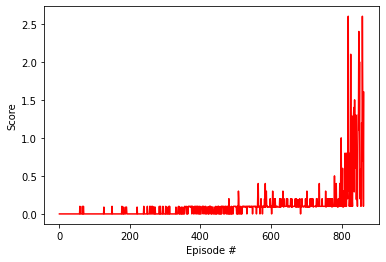

In [8]:
scores = tennis()

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores, 'r-')
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()


In [ ]:
env.close()

## Viewing the trained agents

In [13]:
agent_0 = MADDPG(24, 64, 64, 2, 2, 0, 0.95, 1e-2, 1e-3, 1e-3, 48)
agent_1 = MADDPG(24, 64, 64, 2, 2, 1, 0.95, 1e-2, 1e-3, 1e-3, 48)

In [14]:
agent_0.local_actor.load_state_dict(torch.load('checkpoint_actor_0.pth'))
agent_0.target_actor.load_state_dict(torch.load('checkpoint_actor_0.pth'))
agent_0.local_critic.load_state_dict(torch.load('checkpoint_critic_0.pth'))
agent_0.target_critic.load_state_dict(torch.load('checkpoint_critic_0.pth'))

agent_1.local_actor.load_state_dict(torch.load('checkpoint_actor_1.pth'))
agent_1.target_actor.load_state_dict(torch.load('checkpoint_actor_1.pth'))
agent_1.local_critic.load_state_dict(torch.load('checkpoint_critic_1.pth'))
agent_1.target_critic.load_state_dict(torch.load('checkpoint_critic_1.pth'))

<All keys matched successfully>

In [15]:
rewards_overall = np.zeros(2)

for episode in range(10):
    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment
    states = env_info.vector_observations                  # get the current state
    obs = [agent_obs for agent_obs in states]
    score = 0                                              # initialize the score

    for t in range(10):
        agent_0_action = agent_0.act(obs[0], add_noise=False)
        agent_1_action = agent_1.act(obs[1], add_noise=False)
        
        actions_array = np.stack([agent_0_action, agent_1_action])
        
        env_info = env.step(actions_array)[brain_name]  

        next_states = env_info.vector_observations
        next_obs = [agent_obs for agent_obs in next_states]

        rewards = np.array(env_info.rewards)
        dones = np.array(env_info.local_done)

        obs = next_obs
        
        rewards_overall += rewards
        
        if np.any(dones):
            break

print(rewards_overall/(episode+1))

[0.02 0.03]


In [16]:
env.close()